In [20]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="7"

import tqdm
import h5py
import clip
import torch
from torch.utils.data import DataLoader
from dataloader_video import VideoCLIPDataset

import math
import urllib.request
import clip
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import cv2

#Set the data directory
data_dir = '../../data/'


In [21]:

frame_num = 64
dataset = VideoCLIPDataset(None, frame_num, os.path.join(data_dir, "videos/*.mp4"))
print(len(dataset))

dataloader = DataLoader(
    dataset,
    batch_size=1,
    num_workers = 16,
    shuffle=False
)
data_iter = iter(dataloader)

40


In [22]:
# Load CLIP model.
clip_model = "ViT-B/32" #@param ["RN50", "RN101", "RN50x4", "RN50x16", "ViT-B/32", "ViT-B/16"]
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

## Extract Feature

In [23]:
# os.makedirs(os.path.join(data_dir, 'frame_feat'))
dataset_feats = h5py.File(os.path.join(data_dir, "frame_feat/clip_patch_feat_all.h5"), "w")
dataset_feats.create_dataset("features", (len(dataset), frame_num, 17, 512))
dataset_feats.create_dataset("ids", (len(dataset), ), 'S50')
# dataset_feats.close()

<HDF5 dataset "ids": shape (40,), type "|S50">

In [24]:
global_index = 0
video_ids = {}
data_iter = iter(dataloader)
for batch in tqdm.tqdm(data_iter):
    batch_size = batch['video'].shape[0]
    for i in range(batch_size):
        for j in range(frame_num):
            with torch.no_grad():  
                image_features = model.encode_image(batch['video'][i][j].cuda())
            dataset_feats['features'][global_index, j] = image_features.detach().cpu().numpy()
        dataset_feats['ids'][global_index] = batch['vid'][i].split('/')[-1].strip('.mp4').encode("ascii", "ignore")  #b'../data_582/videos/bathroom_cabinet_2.mp4' =>'bathroom_cabinet_2'
        print(dataset_feats['ids'][global_index])
        global_index += 1
    



  0%|          | 0/40 [00:00<?, ?it/s]

1


  2%|▎         | 1/40 [00:06<04:22,  6.72s/it]

b'using_computer_2'
1


  5%|▌         | 2/40 [00:07<01:59,  3.15s/it]

b'watch_tv_1'
1


  8%|▊         | 3/40 [00:07<01:13,  1.98s/it]

b'wash_glass_3'
1


 10%|█         | 4/40 [00:08<00:51,  1.44s/it]

b'using_microwave_0'
1


 12%|█▎        | 5/40 [00:09<00:39,  1.13s/it]

b'using_computer_0'
1


 15%|█▌        | 6/40 [00:09<00:32,  1.06it/s]

b'using_dishwasher_3'
1


 18%|█▊        | 7/40 [00:10<00:26,  1.22it/s]

b'using_dishwasher_1'
1


 20%|██        | 8/40 [00:10<00:24,  1.33it/s]

b'using_stove_2'
1


 22%|██▎       | 9/40 [00:11<00:22,  1.39it/s]

b'using_stove_1'
1


 25%|██▌       | 10/40 [00:12<00:20,  1.46it/s]

b'using_oven_3'
1


 28%|██▊       | 11/40 [00:12<00:19,  1.50it/s]

b'read_book_0'
1


 30%|███       | 12/40 [00:13<00:18,  1.49it/s]

b'using_microwave_2'
1


 32%|███▎      | 13/40 [00:14<00:17,  1.52it/s]

b'bathroom_cabinet_0'
1


 35%|███▌      | 14/40 [00:14<00:16,  1.57it/s]

b'using_oven_1'
1


 38%|███▊      | 15/40 [00:15<00:15,  1.60it/s]

b'bedroom_cabinet_3'
1


 40%|████      | 16/40 [00:15<00:14,  1.62it/s]

b'wash_glass_1'
1


 42%|████▎     | 17/40 [00:16<00:13,  1.64it/s]

In [17]:
#Close the file pointer
dataset_feats.close()

# Check the extracted feature


In [18]:
import os.path as osp
import h5py
data_path = '../data'
encoding = 'utf-8'
frame_feats = {}
app_feat_file = osp.join(data_dir, f'frame_feat/clip_patch_feat_all.h5')
with h5py.File(app_feat_file, 'r') as fp:
        vids = fp['ids']
        feats = fp['features']
        print(feats.shape)  # v_num, clip_num, feat_dim
        for id, (vid, feat) in enumerate(zip(vids, feats)):
            vid = vid.decode(encoding)
            frame_feats[vid] = feat

fp.close()
frame_feats

(40, 32, 17, 512)


{'using_computer_2': array([[[ 2.35107422e-01, -1.33178711e-01, -9.52148438e-02, ...,
           5.30761719e-01, -3.26171875e-01, -4.04785156e-01],
         [-1.27319336e-01,  5.62744141e-02, -1.39160156e-01, ...,
           7.15820312e-01, -1.20849609e-01, -1.87255859e-01],
         [ 4.23095703e-01,  3.37890625e-01, -5.91430664e-02, ...,
           4.68750000e-01,  5.05676270e-02, -1.28295898e-01],
         ...,
         [ 4.57763672e-01,  1.00463867e-01, -9.85107422e-02, ...,
           4.03808594e-01, -2.45971680e-02, -1.13281250e-01],
         [ 3.26660156e-01,  2.57812500e-01, -1.73461914e-01, ...,
           9.21875000e-01,  8.01391602e-02,  2.15698242e-01],
         [ 1.39770508e-01,  1.26831055e-01, -1.85180664e-01, ...,
           6.72363281e-01, -2.26593018e-02, -3.89404297e-01]],
 
        [[ 1.66748047e-01, -8.22753906e-02, -8.45947266e-02, ...,
           2.58056641e-01, -2.20458984e-01, -3.32031250e-01],
         [ 3.73535156e-01, -1.64184570e-02, -2.66357422e-01, ...,
 

## Check Results

In [19]:
batch = data_iter.next()

AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute 'next'

In [ ]:
# Load CLIP model.
clip_model = "ViT-B/32" #@param ["RN50", "RN101", "RN50x4", "RN50x16", "ViT-B/32", "ViT-B/16"]
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(clip_model, device=device, jit=False)

In [ ]:
def load_image(raw_img, resize=None, pil=False):
    if isinstance(raw_img, str):
        image = Image.open(raw_img).convert("RGB")
    else:
        image = Image.fromarray(raw_img).convert("RGB")
    
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.

def viz_patches(x, figsize=(20, 20), patch_idx=None, topk=None, t=5):
    # x: num_patches, 3, patch_size, patch_size
    n = x.shape[0]
    nrows = int(math.sqrt(n))
    _, axes = plt.subplots(nrows, nrows, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):            
        im = x[i].permute(1, 2, 0).numpy()
        im = (im * 255.).round().astype(np.uint8)
        if patch_idx is not None and i == patch_idx:
            im[0:t] = (255, 0, 0)
            im[im.shape[0]-t:] = (255, 0, 0)
            im[:, 0:t] = (255, 0, 0)
            im[:, im.shape[1]-t:] = (255, 0, 0)
        if topk is not None:
            if i in topk and i != patch_idx:
                im[0:t] = (255, 255, 0)
                im[im.shape[0]-t:] = (255, 255, 0)
                im[:, 0:t] = (255, 255, 0)
                im[:, im.shape[1]-t:] = (255, 255, 0)
        ax.imshow(im)
        ax.axis("off")
    plt.show()

def patchify(image_path, resolution, patch_size, patch_stride=None):
    img_tensor = transforms.ToTensor()(load_image(image_path, resolution, True))
    if patch_stride is None:
        patch_stride = patch_size
    patches = img_tensor.unfold(
        1, patch_size, patch_stride).unfold(2, patch_size, patch_stride)
    patches = patches.reshape(3, -1, patch_size, patch_size).permute(1, 0, 2, 3)
    return patches  # N, 3, patch_size, patch_size

patches:  torch.Size([16, 3, 224, 224])


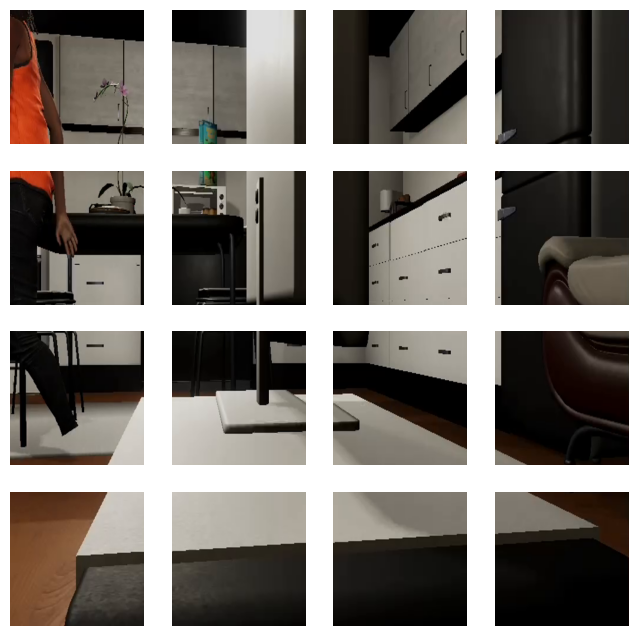

In [ ]:
image_resolution = 224 * 4
patch_size = 224
image_index = 0
one_frame = batch['raw_frame'][0][image_index].permute(1,2,0).numpy()
raw_patches = patchify(one_frame, image_resolution, patch_size, patch_stride=None)
print("patches: ", raw_patches.shape)
viz_patches(raw_patches, figsize=(8, 8))

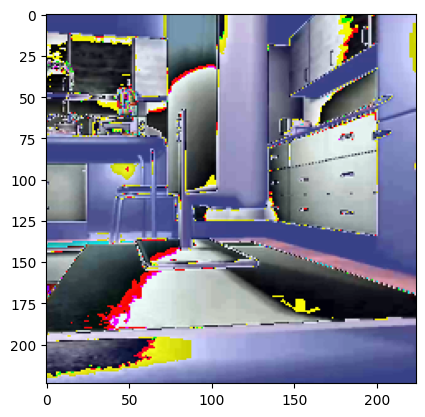

In [ ]:
plt.imshow((batch['video'][0][image_index][0].permute(1, 2, 0).numpy() * 255.).round().astype(np.uint8))
plt.show()

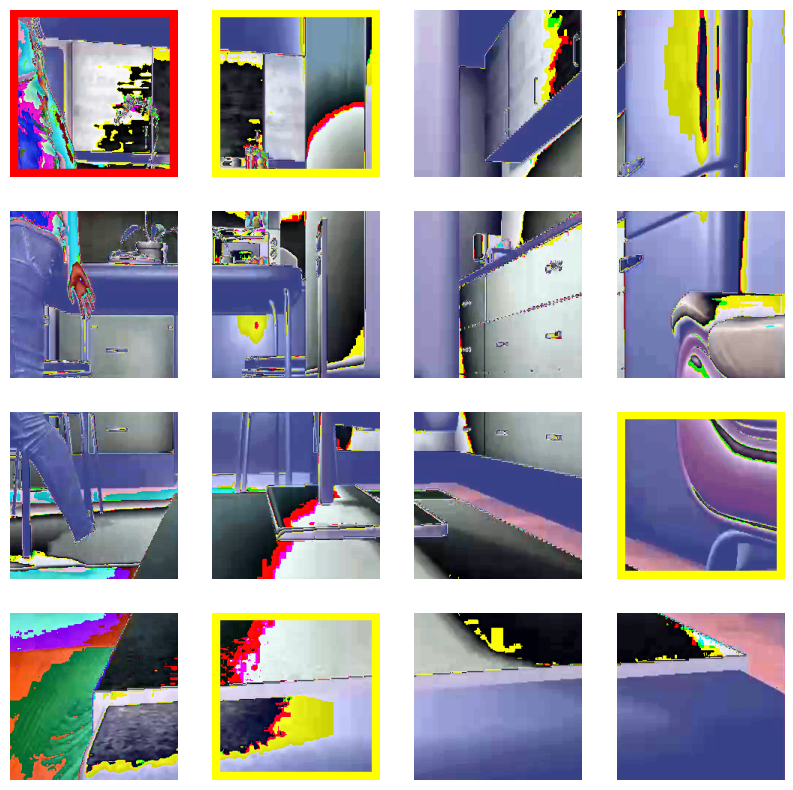

In [ ]:
#@title Detect
patches = batch['video'][0][image_index][1:]

clip_model = "ViT-B/32" #@param ["RN50", "RN101", "RN50x4", "RN50x16", "ViT-B/32", "ViT-B/16"]
image_caption = 'green flower' #@param {type:"string"}
topk =  4#@param {type:"integer"}

text_input = clip.tokenize([image_caption]).to(device)

patches_pad = patches.to(device)

with torch.no_grad():
    patch_embs = model.encode_image(patches_pad)
    text_embs = model.encode_text(text_input)
    patch_embs = patch_embs / patch_embs.norm(dim=-1, keepdim=True)
    text_embs = text_embs / text_embs.norm(dim=-1, keepdim=True)
    sim = patch_embs @ text_embs.t()
    idx_max = sim.argmax().item()
    topk_idxs = torch.topk(sim.flatten(), topk)[-1].cpu().numpy().tolist()

viz_patches(patches, figsize=(10, 10), patch_idx=idx_max, topk=topk_idxs, t=int(0.05*patch_size))

In [ ]:
#@title Detect
patches = patchify(one_frame, image_resolution, patch_size, patch_stride=None)


# image_caption = 'hand' #@param {type:"string"}
topk =  4#@param {type:"integer"}

text_input = clip.tokenize([image_caption]).to(device)

patches_pad = patches.to(device)

with torch.no_grad():
    patch_embs = model.encode_image(patches_pad)
    text_embs = model.encode_text(text_input)
    patch_embs = patch_embs / patch_embs.norm(dim=-1, keepdim=True)
    text_embs = text_embs / text_embs.norm(dim=-1, keepdim=True)
    sim = patch_embs @ text_embs.t()
    idx_max = sim.argmax().item()
    topk_idxs = torch.topk(sim.flatten(), topk)[-1].cpu().numpy().tolist()

viz_patches(raw_patches, figsize=(10, 10), patch_idx=idx_max, topk=topk_idxs, t=int(0.05*patch_size))